# Decision Tree Model


### Importing Libraries

In [1]:
# 1) Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    precision_score, recall_score,
    f1_score, roc_auc_score,
    classification_report, accuracy_score,
    confusion_matrix
)


### Load Dataset

In [2]:
# 2) Load Data
df = pd.read_csv("student_performance/StudentPerformanceFactorsAdjusted.csv")

### Data Preprocessing

In [10]:
# 3) Encode Categorical Values
label_encoders = {}
categorical_columns = df.select_dtypes(include='object').columns

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 4) Define Features and target
X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score']

# 5) Aggregate Scores into Ranges
def aggregate_classes(score):
    if score >= 55 and score <= 60:
        return "55-60"
    elif score >= 61 and score <= 65:
        return "61-65"
    elif score >= 66 and score <= 70:
        return "66-70"
    elif score >= 71 and score <= 75:
        return "71-75"
    elif score >= 76 and score <= 80:
        return "76-80"
    else:
        return "81+"

# Apply Grouping to Target Variable
y_aggregated = y.map(aggregate_classes)

# 6) Identify Numeric and Categorical Columns
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 7) Create Preprocessing Pipelines
# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# 8) Combine Preprocessing Steps
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 9) Split Data
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_aggregated, test_size=0.2, random_state=42)

# 10) Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# 11) Create the Full Pipeline
# Create and train the full pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))  # Use DecisionTreeClassifier for classification
])

# 12) Hyperparameter Tuning
# Define hyperparameter grid
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',  # Use accuracy for classification
    n_jobs=-1
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Update pipeline with best parameters
full_pipeline = grid_search.best_estimator_

# 13) Train the Model
# Fit the pipeline
full_pipeline.fit(X_train, y_train)

# 14) Evaluate the Model
# Make predictions
y_pred = full_pipeline.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, full_pipeline.predict_proba(X_test), multi_class='ovr')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC:", roc_auc)


Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
Best cross-validation score: 0.8168883550262775
Accuracy: 0.6232980332829047
Precision: 0.6773756855142258
Recall: 0.6232980332829047
F1 Score: 0.6444769173571819
AUC: 0.6848986677453711


### Compare Datasets

In [11]:
# Assuming 'default_pipeline' is the pipeline without hyperparameter tuning
default_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit the default pipeline
default_pipeline.fit(X_train, y_train)

# Make predictions with the default pipeline
y_pred_default = default_pipeline.predict(X_test)

# Calculate metrics for the default pipeline
accuracy_default = accuracy_score(y_test, y_pred_default)
precision_default = precision_score(y_test, y_pred_default, average='weighted', zero_division=0)
recall_default = recall_score(y_test, y_pred_default, average='weighted')
f1_default = f1_score(y_test, y_pred_default, average='weighted')
roc_auc_default = roc_auc_score(y_test, default_pipeline.predict_proba(X_test), multi_class='ovr')

print("Default Pipeline Metrics:")
print("Accuracy:", accuracy_default)
print("Precision:", precision_default)
print("Recall:", recall_default)
print("F1 Score:", f1_default)
print("AUC:", roc_auc_default)

# Calculate metrics for the tuned model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, full_pipeline.predict_proba(X_test), multi_class='ovr')

# Print metrics for the tuned model
print("\nTuned Pipeline Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC:", roc_auc)

# Compare the metrics
print("\nComparison with Tuned Pipeline:")
print("Tuned Accuracy vs Default Accuracy:", accuracy, "vs", accuracy_default)
print("Tuned Precision vs Default Precision:", precision, "vs", precision_default)
print("Tuned Recall vs Default Recall:", recall, "vs", recall_default)
print("Tuned F1 vs Default F1:", f1, "vs", f1_default)
print("Tuned AUC vs Default AUC:", roc_auc, "vs", roc_auc_default)

# Print final test set accuracy
print("\nFinal Test Set Accuracy (Tuned Model):", accuracy)


Default Pipeline Metrics:
Accuracy: 0.659606656580938
Precision: 0.6825236939876713
Recall: 0.659606656580938
F1 Score: 0.6699372857451119
AUC: 0.6558477088309805

Tuned Pipeline Metrics:
Accuracy: 0.6232980332829047
Precision: 0.6773756855142258
Recall: 0.6232980332829047
F1 Score: 0.6444769173571819
AUC: 0.6848986677453711

Comparison with Tuned Pipeline:
Tuned Accuracy vs Default Accuracy: 0.6232980332829047 vs 0.659606656580938
Tuned Precision vs Default Precision: 0.6773756855142258 vs 0.6825236939876713
Tuned Recall vs Default Recall: 0.6232980332829047 vs 0.659606656580938
Tuned F1 vs Default F1: 0.6444769173571819 vs 0.6699372857451119
Tuned AUC vs Default AUC: 0.6848986677453711 vs 0.6558477088309805

Final Test Set Accuracy (Tuned Model): 0.6232980332829047


### Data Visualizations

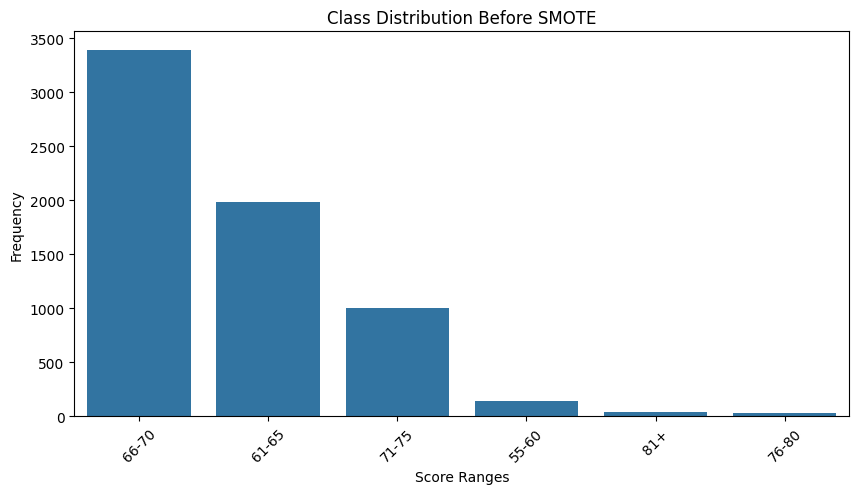

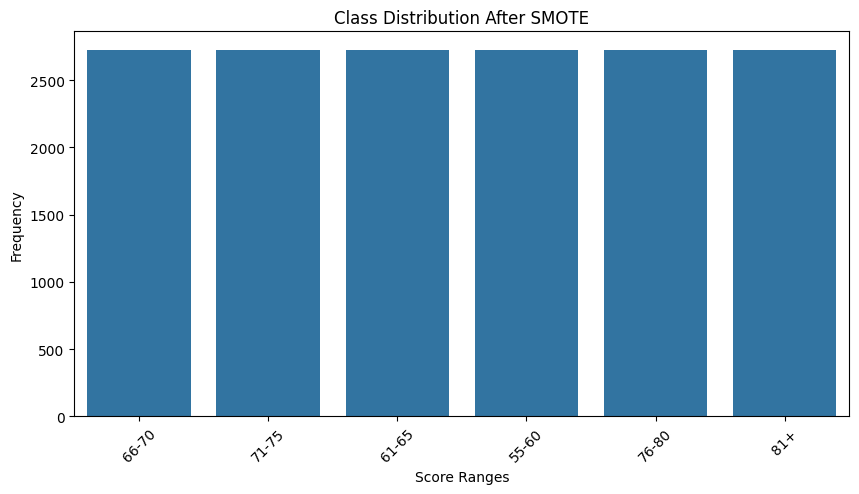

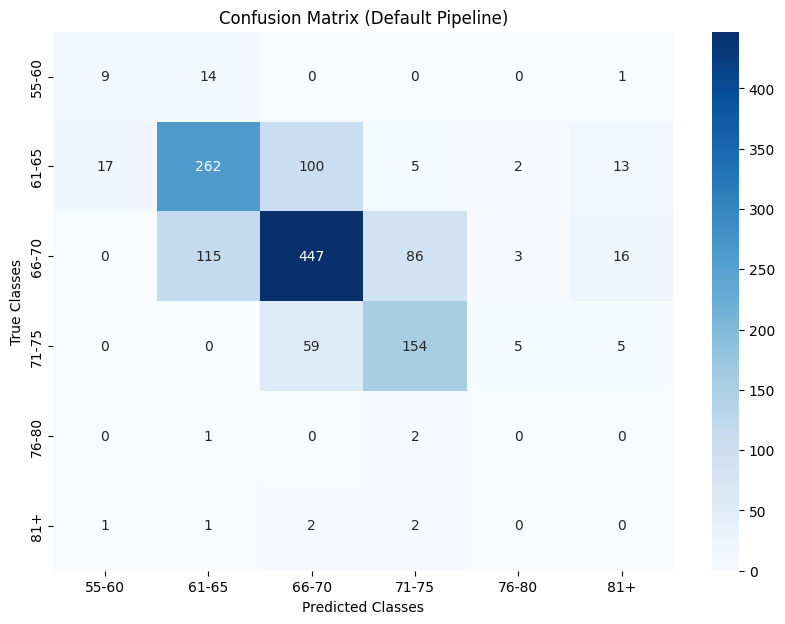

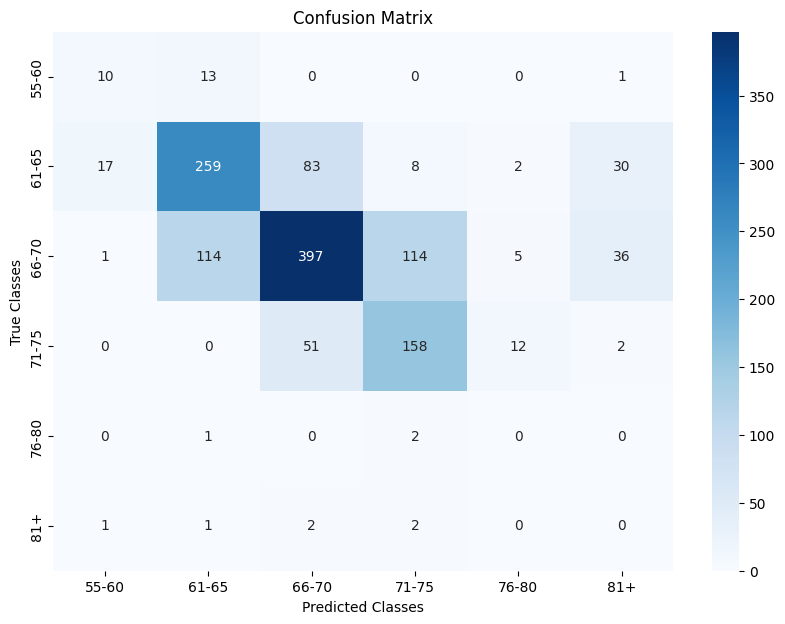

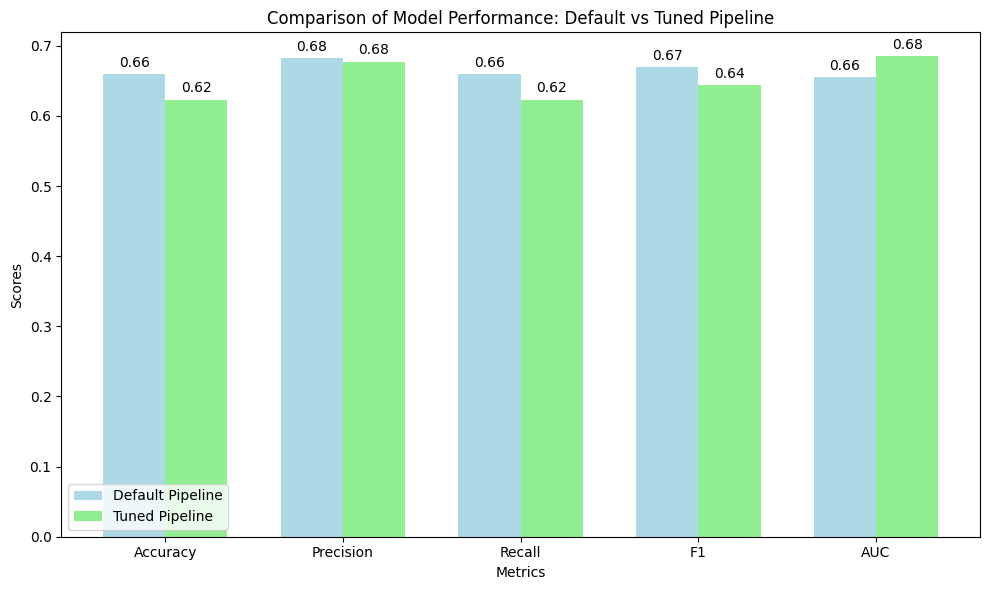


Tuned Decision Tree Metrics:
              precision    recall  f1-score   support

       55-60       0.34      0.42      0.38        24
       61-65       0.67      0.65      0.66       399
       66-70       0.74      0.60      0.66       667
       71-75       0.56      0.71      0.62       223
       76-80       0.00      0.00      0.00         3
         81+       0.00      0.00      0.00         6

    accuracy                           0.62      1322
   macro avg       0.39      0.39      0.39      1322
weighted avg       0.68      0.62      0.64      1322



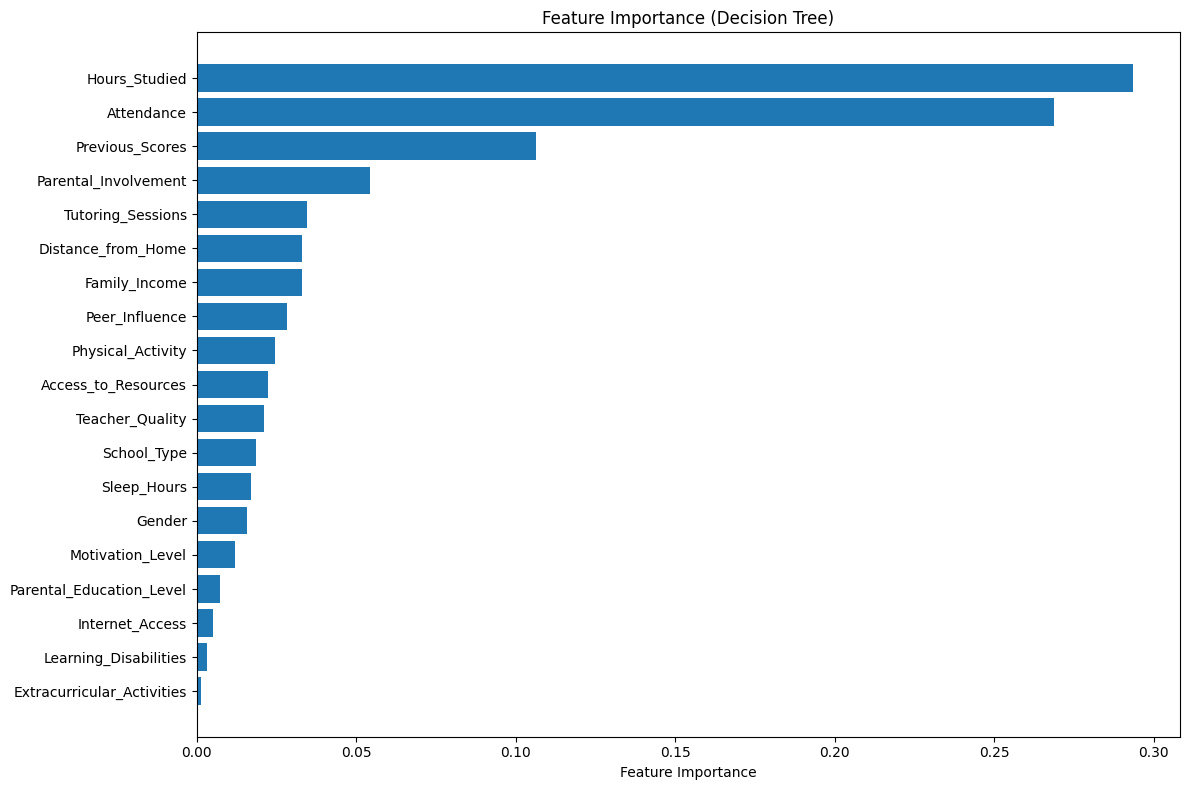

In [12]:
# 1) Visualize Class Distribution Before SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(x=y_aggregated)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Score Ranges')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# 2) Visualize Class Distribution After SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Score Ranges')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# 3) Confusion Matrix (Default)
cm_default = confusion_matrix(y_test, y_pred_default, labels=default_pipeline.classes_)

# Plotting the confusion matrix for the default pipeline
plt.figure(figsize=(10, 7))
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', xticklabels=default_pipeline.classes_, yticklabels=default_pipeline.classes_)
plt.title('Confusion Matrix (Default Pipeline)')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

# 4) Confusion Matrix (Tuned)
cm = confusion_matrix(y_test, y_pred, labels=full_pipeline.classes_)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_pipeline.classes_, yticklabels=full_pipeline.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

# 5) Metric Comparison Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
default_metrics = [accuracy_default, precision_default, recall_default, f1_default, roc_auc_default]
tuned_metrics = [accuracy, precision, recall, f1, roc_auc]

# Create a bar chart for metric comparison
x = range(len(metrics))  # x locations for the groups
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars
bars1 = ax.bar(x, default_metrics, width, label='Default Pipeline', color='lightblue')
bars2 = ax.bar([p + width for p in x], tuned_metrics, width, label='Tuned Pipeline', color='lightgreen')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance: Default vs Tuned Pipeline')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(metrics)
ax.legend()

# Adding value labels on top of the bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',  # Format the height to 2 decimal places
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 6) Display metrics for the tuned model
print("\nTuned Decision Tree Metrics:")
print(classification_report(y_test, y_pred, zero_division=1))

# 7) Important Features Chart
def plot_feature_importance(pipeline, feature_names):
    plt.figure(figsize=(12, 8))
    importances = pipeline.named_steps['classifier'].feature_importances_  # Access feature importances from the classifier
    indices = np.argsort(importances)
    plt.barh(range(len(importances)), importances[indices])
    plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance (Decision Tree)')
    plt.tight_layout()
    plt.show()

plot_feature_importance(full_pipeline, X.columns)  # Pass the full pipeline and feature names
